# Projeto WPT Eletromagnetismo - 2023.2 - Prof. Carlos Marmo
------------------------------------------------------------
### - Gustavo Eliziario Stevenson de Oliveira
### - Alberto Carrera
### - Pedro Civita
### - Bruno Falcao
### - Rafael Niccheri

## Importando Bibliotecas

In [471]:
#Imports para o projeto
import numpy as np
from cmath import *
from numpy import linalg
import matplotlib.pyplot as plt
from math import *

## Funções do projeto WPT (Wireless Power Transfer)

In [472]:
# R1, R2, Rc => Resistências das bobinas primárias e secundárias
# L1 = L2 = L => A indutância das bobinas é igual
# M = sqrt(L1*L2) => Indutância mútua
# C1 = C2 = C => A capacitância dos capacitores é igual
# k => Coeficiente de acoplamento

#Função para cálculo da corrente no primário e secundário
def CalcularTransformadorProjeto(v1, rc, r, l, k, c, f): #Calcula as correntes do primário e secundário e a tensão no secundário
    w = 2*pi*f

    xl = w*l*1j
    xc = 1/(w*c*1j)
    m = k*l
    xm = m*w*1j
    
    Z=np.array([[r+xl+xc, -xm],[-xm, xl+r+1/(1/rc+1/xc)]])
    V=np.array([v1,0])
    I=np.dot(linalg.inv(Z),V)

    Zeq = 1/(1/rc+1/xc)
    V2 = I[1]*Zeq

    return I[0],I[1], V2

def CalcularTransformador_projeto(Uf, R1, R2, Rc, L, C, k, f):
    w = 2*pi*f
    XL = 1j*w*L
    XC = 1/(1j*w*C)
    M = k*L
    XM = 1j*w*M
    Z=np.array([[R1+XL+XC, -XM],[-XM, XL+R2+((Rc*XC)/(Rc+XC))]])
    V=np.array([Uf,0])
    i=np.dot(linalg.inv(Z),V)
    return i[0], i[1]

def CalcularTransformador_projeto2(Uf, R1, R2, Rc, L1, L2, C, k, f):
    if f == 0:
        # Retorna zeros ou None para indicar que o cálculo foi ignorado
        return 0, 0, 0
    w = 2 * pi * f

    xl1 = w * L1 * 1j
    xl2 = w * L2 * 1j
    xc = 1 / (w * C * 1j) if w * C != 0 else np.inf*1j

    m = k * sqrt(L1 * L2)
    xm = m * w * 1j
    
    Z = np.array([[R1 + xl1 + xc, -xm], [-xm, xl2 + R2 + 1 / (1 / Rc + 1 / xc if w * C != 0 else 0)]])
    V = np.array([Uf, 0])
    I = np.dot(linalg.inv(Z), V)

    Zeq = 1 / (1 / Rc + 1 / xc) if w * C != 0 else Rc
    V2 = I[1] * Zeq

    return I[0], I[1], V2

def CalculaFrequenciaRessonancia(L, C):
    if L == 0 or C == 0:
        # Retorna zero ou None para indicar que o cálculo foi ignorado
        return 0
    
    return 1 / (2 * pi * sqrt(L * C))

# Função para calcular a potência real ajustada para ignorar valores zero
def Calcula_Potencia(V, i):
    if V == 0 or i == 0:
        # Retorna zero para indicar que não há potência
        return 0
    return V / sqrt(2) * i.conjugate() / sqrt(2)

# Função para calcular a eficiência ajustada para ignorar valores zero
def calcula_eficiencia(S1, S2):
    if S1.real == 0:
        # Retorna zero para indicar que a eficiência não pode ser calculada
        return 0
    return S2.real / S1.real

def annot_max(x,y, ax=None): # Função para anotar o ponto máximo do gráfico
    ymax = max(y)
    xmax = x[y.index(ymax)]
    text= "x={:.3f}, y={:.3f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)

# Etapa 1

## 1. Elaborando diagrama do modelo eletronico do circuito WPT
 
Essa atividade tem objetivo de especificar o modelo eletrodinâmico WPT por meio de um circuito. Para isso, o modelo do transformador deve ser adaptado de modo a considerar o parâmetro $k$ e os capacitores $C_1$ e $C_2$, lembrado que $C_1$ deve estar em serie com a bobina primária, e $C_2$ em paralelo com a secundária. No projeto, iremos considerar que as bobinas são de mesma dimensões, portanto $L_1 = L_2$. Do mesmo modo que os capacitores devem ser iguais ($C_1 = C_2$), de modo que a frequência de ressonância dos conjuntos $LC$ seja a mesma no primário e no secundário.
 
### Modelo do circuito feito no CircuitLab
https://www.circuitlab.com/circuit/jvdk2ygpev75/circuito_eletromag/

<img src="./circuitoWPT.png" width=800px>

## 2. Código do modelo numérico

### Declarando variáveis com valores arbitrários

In [473]:
l  = 0.01   #indutância das bobinas
c = 150e-9 #capacitância do capacitor em série com a bobina primária e em paralelo com a bobina secundária

freqRes = CalculaFrequenciaRessonancia(l, c)
print("Frequencia de ressonancia: ", freqRes)

v1 = 9   #tensão de alimentação da bobina primária

rc = 100  #resistência de carga na bobina secundária
r = 1     #resistência das bobinas

k = 0.2   #coeficiente de acoplamento
m = k*l   #indutância mútua

frequencies = np.arange(1000, 100000, 10) #array de frequências

values = {"i1": [], "i2": [], "v2": []} #dicionário para armazenar os valores de corrente e tensão

Frequencia de ressonancia:  4109.362960409999


## 3. Construção de gráficos de I1 e I2 em função da frequência

### Percorrendo valores de frequência de 1 KHz até 100 KHz para observar o comportamento das correntes i1 e i2

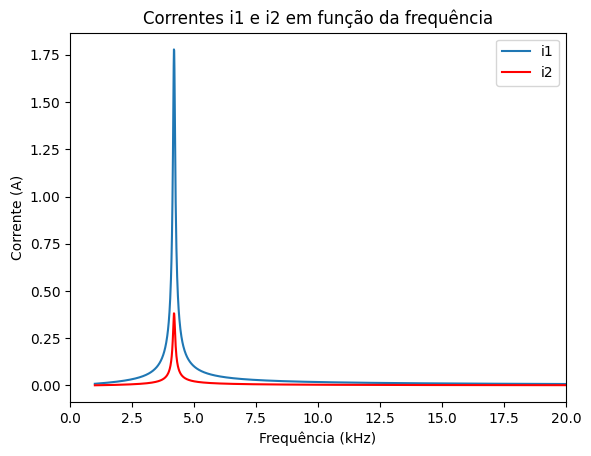

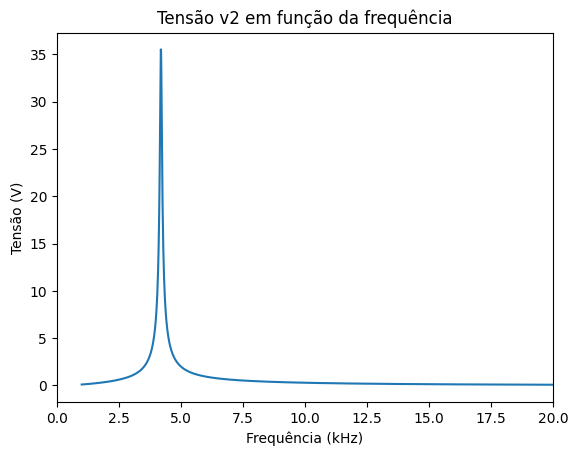

In [474]:
for f in frequencies:
    i1, i2, v2 = CalcularTransformadorProjeto(v1, rc, r, l, k, c, f)
    values["i1"].append(abs(i1))
    values["i2"].append(abs(i2))
    values["v2"].append(abs(v2))
    
plt.plot(frequencies/1e3, values["i1"])
plt.plot(frequencies/1e3, values["i2"], color="red")
plt.legend(["i1", "i2"])
plt.title("Correntes i1 e i2 em função da frequência")
plt.xlabel("Frequência (kHz)")
plt.ylabel("Corrente (A)")
plt.xlim(0, 20)
plt.show()

plt.plot(frequencies/1e3, values["v2"])
plt.title("Tensão v2 em função da frequência")
plt.xlabel("Frequência (kHz)")
plt.ylabel("Tensão (V)")
plt.xlim(0, 20)
plt.show()



In [475]:
# Descobrindo o valor de frequência que causa correntes máximas
f1 = frequencies[values['i1'].index(max(values['i1']))]
f2 = frequencies[values['i2'].index(max(values['i2']))]
f3 = frequencies[values['v2'].index(max(values['v2']))]

print("Frequência que causa corrente máxima no primário: ", f1, "Hz")
print("Frequência que causa corrente máxima no secundário: ", f2, "Hz")
print("Frequência que causa tensão máxima no secundário: ", f3, "V")

Frequência que causa corrente máxima no primário:  4190 Hz
Frequência que causa corrente máxima no secundário:  4190 Hz
Frequência que causa tensão máxima no secundário:  4190 V


#### Para K = 0.2, a frequência de ressonância encontradada através da equação $ \frac{1}{2\pi\sqrt{lc}} $ foi 4109.36 Hz. Já a encontrada pelo valor máximo de i1 e i2 foi 4190 Hz.


#### Observando o impacto de K na tensão e corrente do secundário

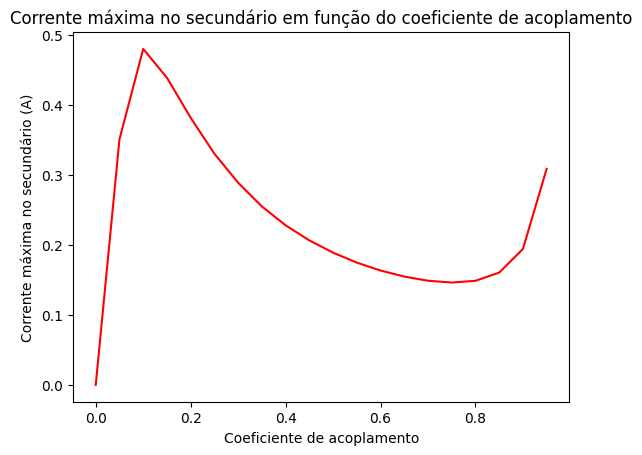

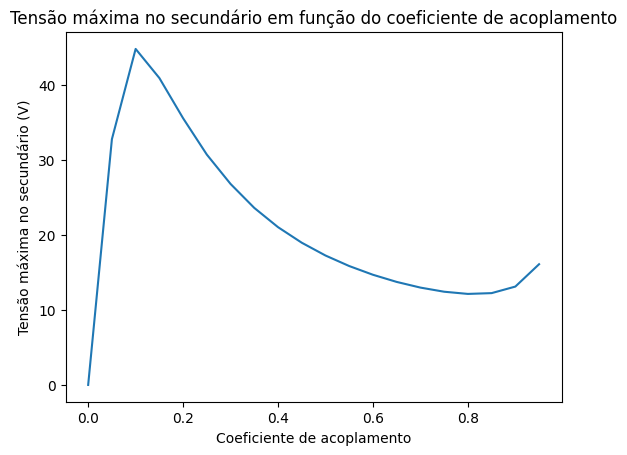

In [476]:
k_list = np.arange(0, 1, 0.05) #array de coeficientes de acoplamento
i2_max = []
v2_max = []
f = 4190
for k in k_list:
    values = {"i1": [], "i2": [], "v2": []} 
    for f in frequencies:
        i1, i2, v2 = CalcularTransformadorProjeto(v1, rc, r, l, k, c, f)
        values["i1"].append(abs(i1))
        values["i2"].append(abs(i2))
        values["v2"].append(abs(v2))
    i2_max.append(max(values["i2"]))
    v2_max.append(max(values["v2"]))	


plt.plot(k_list, i2_max, color="red")
plt.title("Corrente máxima no secundário em função do coeficiente de acoplamento")
plt.ylabel("Corrente máxima no secundário (A)")
plt.xlabel("Coeficiente de acoplamento")
plt.show()

plt.plot(k_list, v2_max)
plt.title("Tensão máxima no secundário em função do coeficiente de acoplamento")
plt.ylabel("Tensão máxima no secundário (V)")
plt.xlabel("Coeficiente de acoplamento")
plt.show()

In [477]:
k1 = k_list[i2_max.index(max(i2_max))]
k2 = k_list[v2_max.index(max(v2_max))]

print(f"Coeficiente de acoplamento: {k1} causa corrente máxima {max(i2_max)}A no secundário: ")
print(f"Coeficiente de acoplamento: {k2} causa tensão máxima {max(v2_max)}V no secundário: ")

Coeficiente de acoplamento: 0.1 causa corrente máxima 0.48012619975287585A no secundário: 
Coeficiente de acoplamento: 0.1 causa tensão máxima 44.742626923414896V no secundário: 


## 4. Construção de um gráfico do módulo da tensão $V_2$ pela frequência de ressonância, para 6 diferentes indutâncias e para 5 diferentes capacitores (Análise para chegar na nossa montagem da bobina)

### Analisando o comportamento da tensão V2 no secundário pela frequência de ressonância para diferentes indutâncias

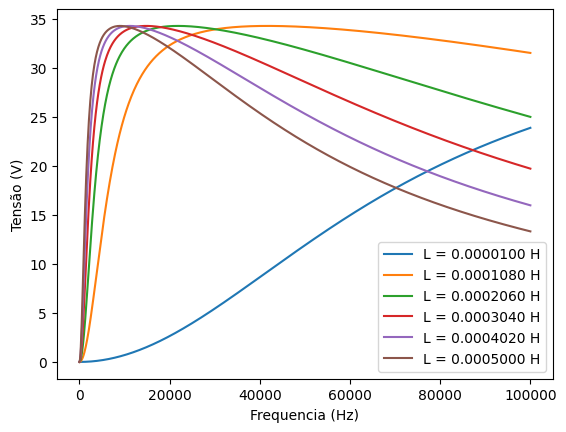

In [478]:
#Criando uma lista para as legendas do gráfico
lista_L = np.linspace(10e-6, 500e-6, 6)
lista_legendas = []
for l in lista_L:
    legenda = str("L = {:.7f} H".format(l))
    lista_legendas.append(legenda)

Rc = 100
lista_freq_r = np.linspace(1, 100000, 1000)
lista_V2 = []

for l in lista_L:
    lista_V2_individual = []
    for freq in lista_freq_r:
        # Cálculo da capacitância
        C = 1/((freq**2)*(4*pi**2)*l)
        I1, I2 = CalcularTransformador_projeto(v1, 1, 1, Rc, l, C, 0.2, freq)
        #Cálculo da tensão no secundário
        XC = 1/(1j*freq*2*pi*C)
        V2 = I2*((Rc*XC)/(Rc+XC))
        lista_V2_individual.append(abs(V2))
    lista_V2.append(lista_V2_individual)

# Plot de V2 por freq para cada valor de L
lista_L = list(lista_L)
i = 0
for lista_V2_individual in lista_V2:
    # lista_freq_r = lista_freq_r[]
    # lista_V2_individual = lista_V2_individual[]
    plt.plot(lista_freq_r, lista_V2_individual, label=lista_legendas[i])
    i += 1
plt.xlabel("Frequencia (Hz)")
plt.ylabel("Tensão (V)")
#plt.xlim(1, 20000)
plt.legend()
plt.show()


### Analisando o comportamento da tensão V2 no secundário pela frequência de ressonância para diferentes capacitâncias

Capacitor de capacitância: 0.1e-6 F
Frequência em que a tensão no secundário é máxima: 56256.69369369369

Capacitor de capacitância: 150e-9 F
Frequência em que a tensão no secundário é máxima: 37538.16216216216

Capacitor de capacitância: 1e-6 F
Frequência em que a tensão no secundário é máxima: 5606.549549549549

Capacitor de capacitância: 4.7e-6 F
Frequência em que a tensão no secundário é máxima: 1202.1891891891892

Capacitor de capacitância: 0.47e-6 F
Frequência em que a tensão no secundário é máxima: 12012.891891891892



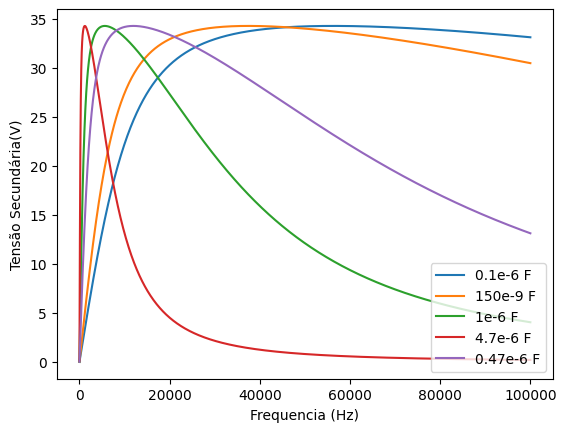

In [479]:
Rc = 100
lista_freq_r = np.linspace(1, 100000, 1000)
lista_V2 = []
lista_C = [0.1e-6, 150e-9, 1e-6, 4.7e-6, 0.47e-6]
for C in lista_C:
    lista_V2_individual = []
    for freq in lista_freq_r:
        # Cálculo da capacitância
        L = 1/((freq**2)*(4*pi**2)*C)
        I1, I2 = CalcularTransformador_projeto(v1, 1, 1, Rc, L, C, 0.2, freq)
        #Cálculo da tensão no secundário
        XC = 1/(1j*freq*2*pi*C)
        V2 = I2*((Rc*XC)/(Rc+XC))
        lista_V2_individual.append(abs(V2))
    lista_V2.append(lista_V2_individual)

# Criando uma lista para as legendas do gráfico
lista_legendas = ["0.1e-6 F", "150e-9 F", "1e-6 F", "4.7e-6 F", "0.47e-6 F"]

# Plot de V2 por freq para cada valor de L
i = 0
for lista_V2_individual in lista_V2:
    print(f'Capacitor de capacitância: {lista_legendas[i]}')
    index_max = lista_V2_individual.index(max(lista_V2_individual))
    print(f'Frequência em que a tensão no secundário é máxima: {lista_freq_r[index_max]}\n')
    plt.plot(lista_freq_r, lista_V2_individual, label=lista_legendas[i])
    i += 1
plt.xlabel("Frequencia (Hz)")
plt.ylabel("Tensão Secundária(V)")
# plt.xlim(1, 20000)
plt.legend(loc='lower right')
plt.show()

## 5. Construção de gráficos das potências e da eficiência em função da frequência

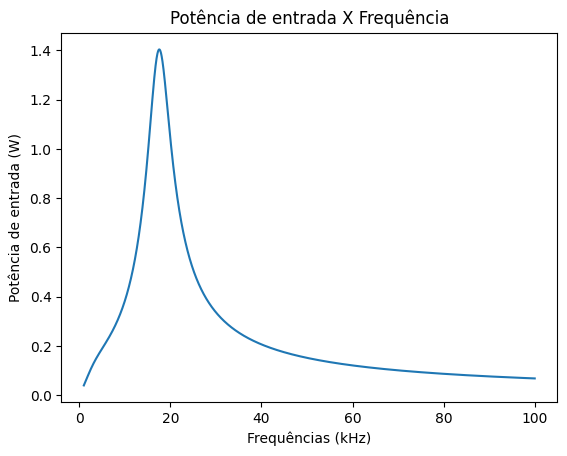

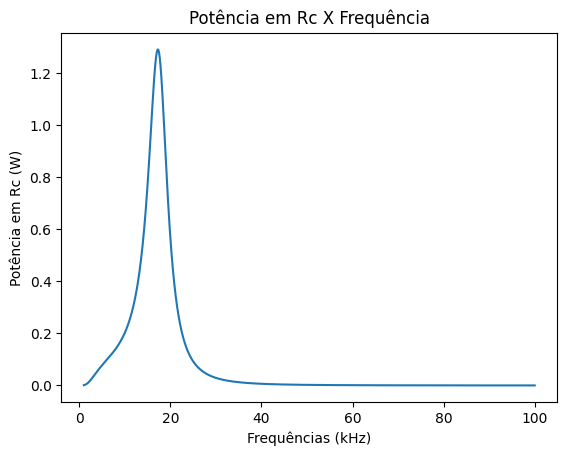

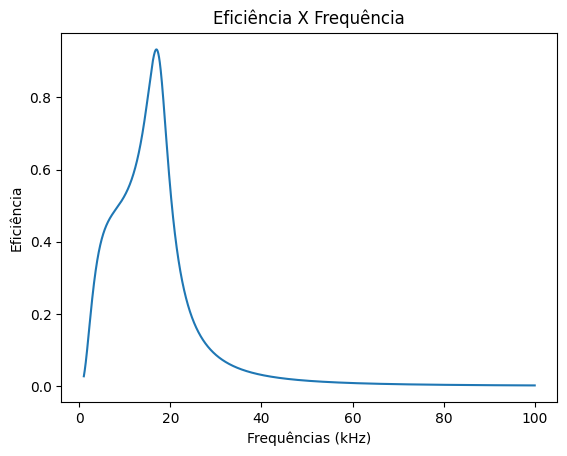

In [480]:
pe  = v1*np.array(values['i1']).conjugate()/2 # potência de entrada

ic = np.array(values['v2']) / rc # corrente no resistor de carga
ps = np.array(values['v2'])*ic.conjugate()/2 # potência de carga

plt.plot(frequencies/1e3, pe.real)
plt.title('Potência de entrada X Frequência')
plt.xlabel('Frequências (kHz)')
plt.ylabel('Potência de entrada (W)')
plt.show()

plt.plot(frequencies/1e3, ps.real)
plt.title('Potência em Rc X Frequência')
plt.xlabel('Frequências (kHz)')
plt.ylabel('Potência em Rc (W)')
plt.show()

plt.plot(frequencies/1e3, ps.real/pe.real)
plt.title('Eficiência X Frequência')
plt.xlabel('Frequências (kHz)')
plt.ylabel('Eficiência')
plt.show()

## 6. Construção de um gráfico que relacione o valor de pico da tensão no secundário (no resistor $𝑅_𝐶$) com o coeficiente de acoplamento $k$

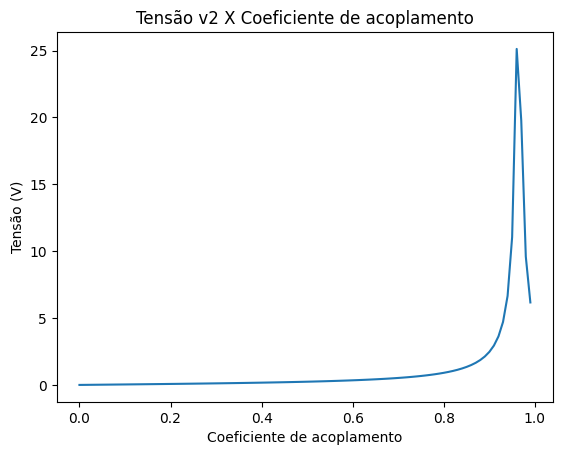

In [481]:
l  = 0.0004622
c = 0.00000015

fr = CalculaFrequenciaRessonancia(L, C)

k_list = np.arange(0, 1, 0.01)
v2_max = []

for k in k_list:
    _,_, v2 = CalcularTransformadorProjeto(v1, rc, r, l, k, c, fr)
    v2_max.append(abs(v2))

plt.plot(k_list, v2_max)
# plt.xlim(0, 0.6)
plt.title("Tensão v2 X Coeficiente de acoplamento")
plt.xlabel("Coeficiente de acoplamento")
plt.ylabel("Tensão (V)")
plt.show()

In [482]:
best_k = k_list[v2_max.index(max(v2_max))]
print(f"O coeficiente de acoplamento: {best_k} é o que garante maior tensão no secundário: {max(v2_max)}V")

O coeficiente de acoplamento: 0.96 é o que garante maior tensão no secundário: 25.122280767765616V


## 7. Simulação das potências reais em função de R1 (resistência no primário)

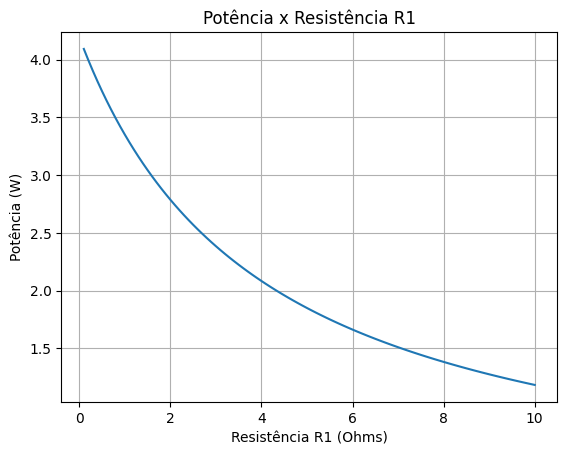

In [483]:
L = 0.0004622
L1 = 0.0004622
L2 = 0.0004622
R2 = 1.771
C = 150e-9
Rc = 100
Uf = rect(9, 0)
uf_simulado = 9*2/pi
incerteza = 0 #Ohms

# Intervalo de variação para R1
lista_R1 = np.linspace(0.1, 10, 100) # Por exemplo, de 0.1 a 10 Ohms
lista_potencia = []

for res1 in lista_R1:
    # Calcular correntes usando a função apropriada
    I1, I2 = CalcularTransformador_projeto(uf_simulado, res1, R2, Rc, L, C, 0.2, 19620)

    potencia = Calcula_Potencia(uf_simulado, I1) # Use os parâmetros apropriados
    lista_potencia.append(potencia.real) # Armazenando a parte real da potência

# Plotar o gráfico
plt.plot(lista_R1, lista_potencia)
plt.title("Potência x Resistência R1")
plt.xlabel("Resistência R1 (Ohms)")
plt.ylabel("Potência (W)")
plt.grid(True)
plt.show()


# Etapa 2

### Refazendo etapa 1 para R1 e R2 diferentes e L1 e L2 diferentes

Para construir nossas bobinas, escolhemos uma capacitância de 150 nF e uma indutância de 0.44 mH para chegar em uma frequência de ressonância de aproximadamente 19620 Hz. Entretanto, após construir as bobinas, percebemos que as suas indutâncias estavam iguais a L1 = 0.0004622 H e L2 = 0.0004622 H. $ \\ $
Por isso, foi necessário recalcular a frequência de ressonância:


In [484]:
# Usaremos o capacitor de 150nF (F pico = 19.620,42 Hz) para calcular a indutância
C = 150e-9
v_real = 9*2/pi
freq = 19620.42342342342
L = 1/((freq**2)*(4*pi**2)*C)
print(f'A indutância para o capacitor de 150nF: {L:.7f} H')
print(f'A indutância para o capacitor de 150nF (aproximado): {L*1000:.2f} mH')

A indutância para o capacitor de 150nF: 0.0004387 H
A indutância para o capacitor de 150nF (aproximado): 0.44 mH


In [485]:
freq_ressonancia = CalculaFrequenciaRessonancia(L, C)
freq_r_og = freq_ressonancia.real
print(f'A frequência de ressonância para o indutância de 0.44 mH: {freq_ressonancia.real} Hz')

A frequência de ressonância para o indutância de 0.44 mH: 19620.423423423417 Hz


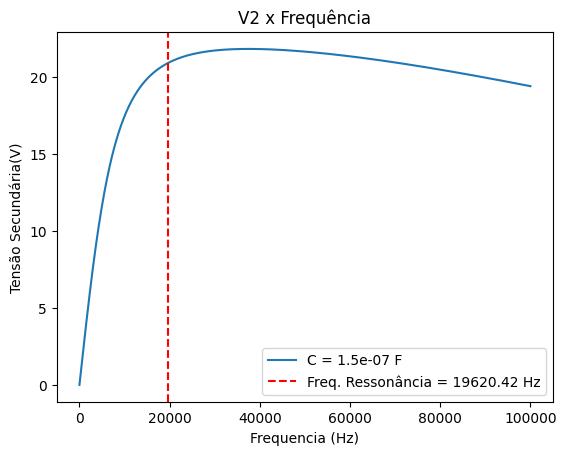

In [486]:
Rc = 100
C = 150e-9
lista_freq = np.linspace(1, 100000, 1000)
lista_V2 = []

# Cálculo para cada frequência
for freq in lista_freq:
    L = 1/((freq**2)*(4*pi**2)*C)
    I1, I2 = CalcularTransformador_projeto(v_real, 1, 1, Rc, L, C, 0.2, freq)
    XC = 1/(1j*freq*2*pi*C)
    V2 = I2*((Rc*XC)/(Rc+XC))
    lista_V2.append(abs(V2))

# Encontrar a frequência de ressonância (máxima tensão no secundário)
freq_max = lista_freq[np.argmax(lista_V2)]

# Plotagem do gráfico
plt.plot(lista_freq, lista_V2, label=f"C = {C} F")
plt.axvline(x=freq_ressonancia.real, color='r', linestyle='--')
plt.xlabel("Frequencia (Hz)")
plt.ylabel("Tensão Secundária(V)")
plt.legend([f"Freq. Ressonância = {freq_ressonancia.real:.2f} Hz"], loc='lower right')
# Truque para adicionar legenda à linha vertical
plt.plot([], [], color='r', linestyle='--', label=f"Freq. Ressonância = {freq_ressonancia.real:.2f} Hz")
plt.legend(loc='lower right')
plt.title("V2 x Frequência")
plt.show()

In [487]:
freq_ressonancia = CalculaFrequenciaRessonancia(L1, C)
print(f'A frequência de ressonância para o indutância de 0.462 mH: {freq_ressonancia.real} Hz')

A frequência de ressonância para o indutância de 0.462 mH: 19114.349889781566 Hz


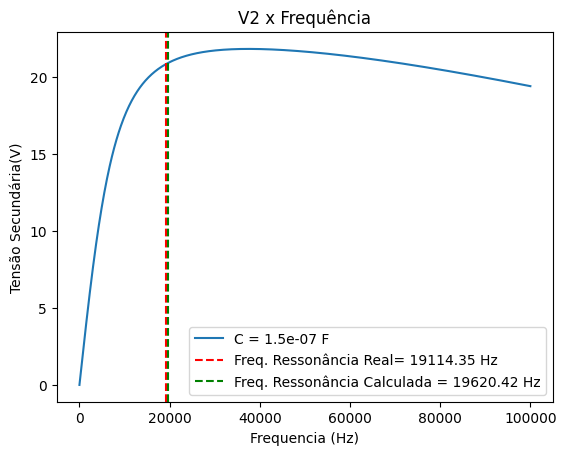

In [488]:
# V2 x Frequencia com nova frequencia de ressonancia

Rc = 100
C = 150e-9
lista_freq = np.linspace(1, 100000, 1000)
lista_V2 = []

# Cálculo para cada frequência
for freq in lista_freq:
    L = 1/((freq**2)*(4*pi**2)*C)
    I1, I2 = CalcularTransformador_projeto(v_real, 1, 1, Rc, L, C, 0.2, freq)
    XC = 1/(1j*freq*2*pi*C)
    V2 = I2*((Rc*XC)/(Rc+XC))
    lista_V2.append(abs(V2))

# Encontrar a frequência de ressonância (máxima tensão no secundário)
freq_max = lista_freq[np.argmax(lista_V2)]

# Plotagem do gráfico
plt.plot(lista_freq, lista_V2, label=f"C = {C} F")
plt.axvline(x=freq_ressonancia.real, color='r', linestyle='--')
plt.axvline(x=freq_r_og, color='g', linestyle='--')
plt.xlabel("Frequencia (Hz)")
plt.ylabel("Tensão Secundária(V)")
plt.legend([f"Freq. Ressonância = {freq_ressonancia.real:.2f} Hz"], loc='lower right')
# Truque para adicionar legenda à linha vertical
plt.plot([], [], color='r', linestyle='--', label=f"Freq. Ressonância Real= {freq_ressonancia.real:.2f} Hz")
plt.plot([], [], color='g', linestyle='--', label=f"Freq. Ressonância Calculada = {freq_r_og:.2f} Hz")
plt.legend(loc='lower right')
plt.title("V2 x Frequência")
plt.show()

### I1 e I2 reais

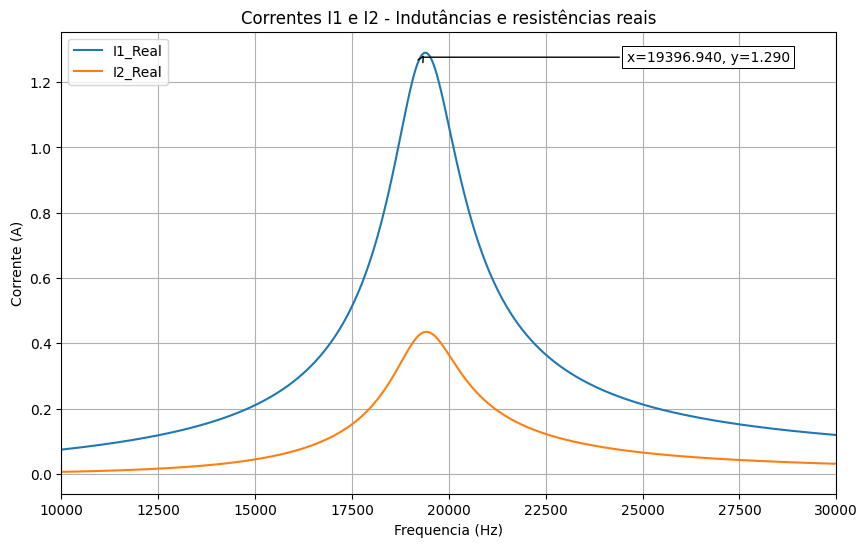

In [489]:
R1 = 1.620
R2 = 1.771
L1 = 0.0004622
L2 = 0.0004622
Rc = 100
K_ideal = 0.17117117117117117
C = 150e-9
lista_freq = np.linspace(10000, 100000, 10000)
V_entrada = 9*2/pi

# Listas para armazenar valores
lista_i1_2 = []
lista_i2_2 = []
lista_v2_2 = []

# Cálculo de I1, I2 e V2 para cada frequência
for freq in lista_freq:
    I1_1, I2_1, V2_1 = CalcularTransformador_projeto2(V_entrada, R1 + incerteza, R2 + incerteza, Rc, L1, L2, C, K_ideal, freq)
    lista_i1_2.append(abs(I1_1))
    lista_i2_2.append(abs(I2_1))
    lista_v2_2.append(abs(V2_1))

# Plotagem de I1 e I2
plt.figure(figsize=(10, 6))
plt.plot(lista_freq, lista_i1_2, label="I1_Real")
plt.plot(lista_freq, lista_i2_2, label="I2_Real")
plt.title('Correntes I1 e I2 - Indutâncias e resistências reais')
plt.xlabel("Frequencia (Hz)")
plt.ylabel("Corrente (A)")
plt.xlim(10000, 30000)
annot_max(lista_freq, lista_i1_2)
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()



### V2 Real

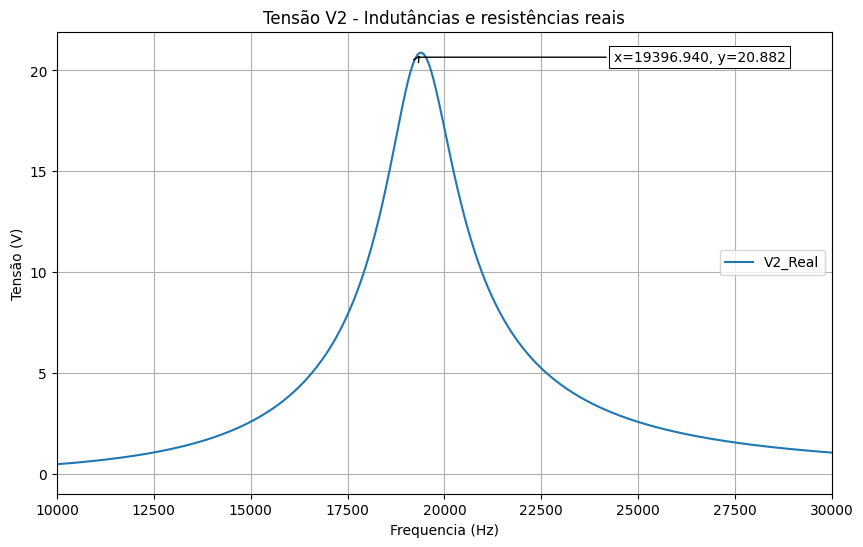

In [490]:
# Plotagem de V2
plt.figure(figsize=(10, 6))
plt.plot(lista_freq, lista_v2_2, label="V2_Real")
plt.title('Tensão V2 - Indutâncias e resistências reais')
plt.xlabel("Frequencia (Hz)")
plt.ylabel("Tensão (V)")
plt.xlim(10000, 30000)
annot_max(lista_freq, lista_v2_2)
plt.legend(loc = 'center right')
plt.grid(True)
plt.show()


## Resultados da Trasmissão de Energia do projeto físico

### Transmissão mais potente
______________________
 
#### d =  3,5cm
 
####  pico a pico = 31V
 
#### V_max = 15.5V

### Trasmissão mais distante
______________________

#### d = 20 cm
 
#### V pico a pico = 1,2V
  
#### V_max =  600mV

## Potencia

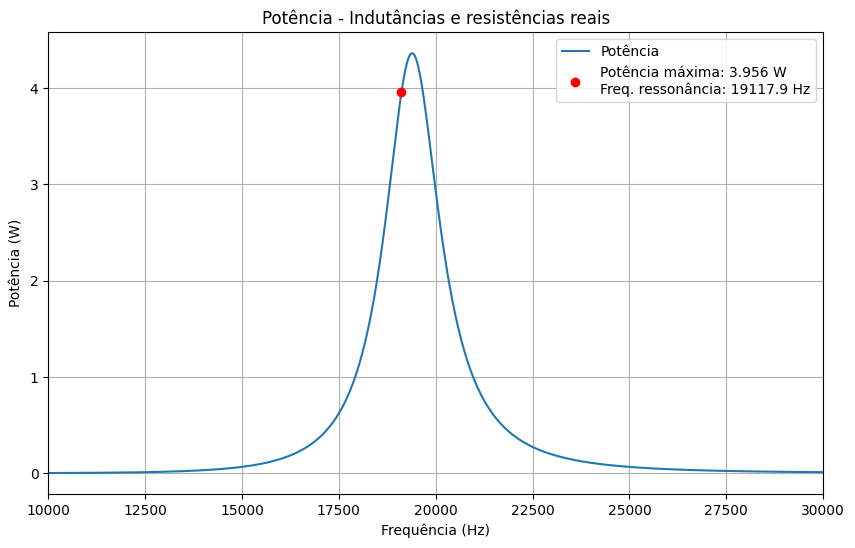

Frequência de ressonância: 19114.349889781566 Hz
Potência máxima na frequência de ressonância: 3.956 W


In [491]:
# potencia maxima na frequencia de ressonancia
freq_ressonancia = CalculaFrequenciaRessonancia(L2, C)
# Encontrar o índice mais próximo da frequência de ressonância
i_ressonancia = np.argmin(np.abs(lista_freq - freq_ressonancia))

# Plotagem de Potencia (W) em função da frequência
lista_potencia = np.array(lista_v2_2)**2 / Rc
i_max_potencia = np.argmax(lista_potencia)

plt.figure(figsize=(10, 6))
plt.plot(lista_freq, lista_potencia, label="Potência")

# Ponto de potência máxima na frequência de ressonância
pot_max_na_ressonancia = lista_potencia[i_ressonancia]
freq_na_ressonancia = lista_freq[i_ressonancia]

plt.plot(freq_na_ressonancia, pot_max_na_ressonancia, 'ro', 
         label=f'Potência máxima: {pot_max_na_ressonancia:.3f} W\nFreq. ressonância: {freq_na_ressonancia:.1f} Hz')

plt.title('Potência - Indutâncias e resistências reais')
plt.xlabel("Frequência (Hz)")
plt.ylabel("Potência (W)")
plt.xlim(10000, 30000)
plt.legend()
plt.grid(True)
plt.show()

print(f'Frequência de ressonância: {freq_ressonancia.real} Hz')
print(f'Potência máxima na frequência de ressonância: {lista_potencia[i_ressonancia]:.3f} W')

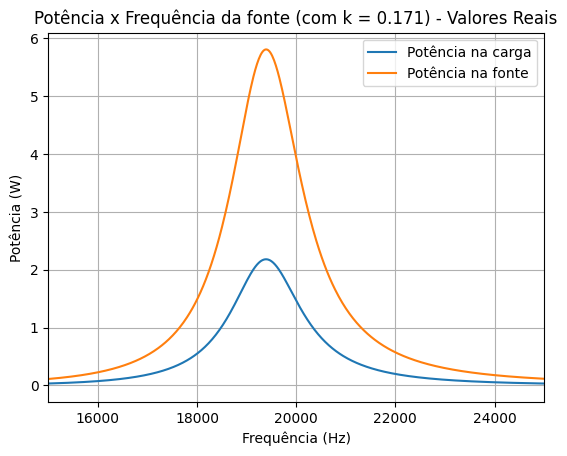

Potência máxima para k = K_ideal: 2.18 W


In [492]:
lista_iRC = []
lista_eficiencia = []
lista_potencia_carga = []
lista_potencia_fonte = []

lista_potencia_carga_2 = []
lista_potencia_fonte_2 = []
lista_eficiencia_2 = []

L = 0.0004622
L1 = 0.0004622
L2 = 0.0004622
C = 150e-9
Rc = 100
Uf = rect(9, 0)
uf_simulado = 9*2/pi
incerteza = 0  #Ohms

lista_freq = np.linspace(10e3, 200e3, 10500)

#Calculando potência e eficiência em função da frequência.
for f in lista_freq:
    i1, i2 = CalcularTransformador_projeto(uf_simulado, 1, 1, Rc, L, C, 0.2, f)
    w = 2*pi*f
    Pot = (Calcula_Potencia(Uf, i1)).real
    lista_potencia_fonte.append(Pot)

    Z_eq_carga = ((1/(1j*w*C))*Rc)/((1/(1j*w*C))+Rc)
    V_carga = i2*Z_eq_carga
    I_Rc = V_carga/Rc
    Pot_carga = (Calcula_Potencia(V_carga, I_Rc)).real

    #Adiciona os resultados na lista
    lista_potencia_carga.append(Pot_carga)
    lista_eficiencia.append(calcula_eficiencia(Pot, Pot_carga))


    # ------------------- Valores Reais ------------------- #

    #Calculando novamente para os valores reais
    i1_2, i2_2, _ = CalcularTransformador_projeto2(uf_simulado, R1 + incerteza, R2 + incerteza, Rc, L1, L2, C, K_ideal, f)
    Pot_2 = (Calcula_Potencia(Uf, i1_2)).real
    lista_potencia_fonte_2.append(Pot_2)

    Z_eq_carga_2 = ((1/(1j*w*C))*Rc)/((1/(1j*w*C))+Rc)
    V_carga_2 = i2_2*Z_eq_carga_2
    I_Rc_2 = V_carga_2/Rc
    Pot_carga_2 = (Calcula_Potencia(V_carga_2, I_Rc_2)).real

    #Adiciona os resultados na lista
    lista_potencia_carga_2.append(Pot_carga_2)
    lista_eficiencia_2.append(calcula_eficiencia(Pot_2, Pot_carga_2))


#Plotando a eficiência em função da frequência - Valores Reais
plt.plot(lista_freq, lista_potencia_carga_2, label="Potência na carga")
plt.plot(lista_freq, lista_potencia_fonte_2, label="Potência na fonte")
plt.title("Potência x Frequência da fonte (com k = 0.171) - Valores Reais")
plt.xlabel("Frequência (Hz)")
plt.ylabel("Potência (W)")
plt.xlim(15000, 25000)
plt.legend()
plt.grid(True)
plt.show()

print(f'Potência máxima para k = K_ideal: {max(lista_potencia_carga_2):.2f} W')

In [493]:
potencia_maxima_real = 15.5**2 / Rc
print(f'Potência medida: {potencia_maxima_real:.2f} W')

Potência medida: 2.40 W


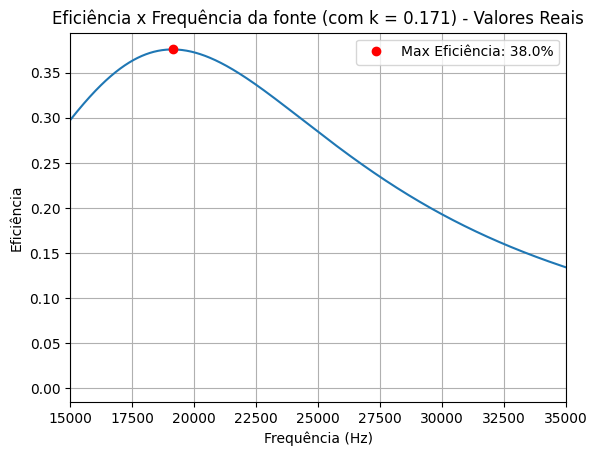

In [494]:
plt.plot(lista_freq, lista_eficiencia_2)
i = lista_eficiencia_2.index(max(lista_eficiencia_2))
plt.plot(lista_freq[i], lista_eficiencia_2[i], 'ro', label=f'Max Eficiência: {round(max(lista_eficiencia_2), 2)*100}%')
plt.title("Eficiência x Frequência da fonte (com k = 0.171) - Valores Reais")
plt.xlabel("Frequência (Hz)")
plt.ylabel("Eficiência")
plt.xlim(15000, 35000)
plt.legend()
plt.grid(True)
plt.show()

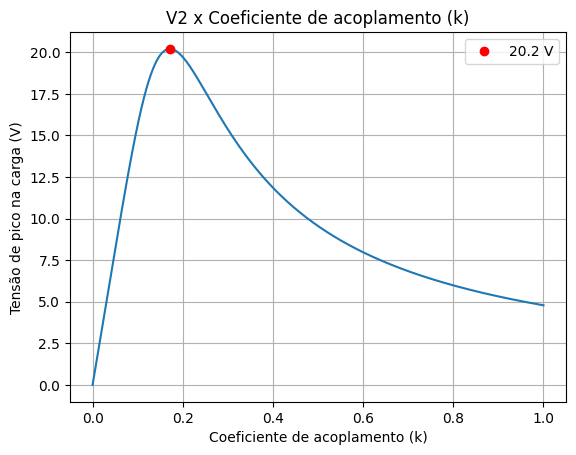

O valor de k para a tensão de pico na carga ser máxima é 0.17117117117117117

A tensão de pico na carga é 20.20030643193871 V

A resistência utilizada para o modelo para o primário e para o secundário foi de 1.620 e 1.771 Ohms, respectivamente.


In [495]:
# Retomando Valores Reais
C = 150e-9
Rc = 100
Uf = rect(9, 0)
V_entrada = 9*2/pi

freq_r = 1/(2*pi*sqrt(L*C))
lista_k = np.linspace(0, 1, 1000)
lista_tensao_pico = []
lista_tensao_pico_2 = []

for k_novo in lista_k:
    i1, i2 = CalcularTransformador_projeto(V_entrada, 1, 1, Rc, L, C, k_novo, freq_r)
    w = 2*pi*freq_r
    Z_eq_carga = ((1/(1j*w*C))*Rc)/((1/(1j*w*C))+Rc)
    V_carga = i2*Z_eq_carga
    lista_tensao_pico.append(abs(V_carga))


    # ------------------- Valores Reais ------------------- #

    f2 = 19620.42 #Frequência real de operação - 20kHz
    i1_2, i2_2, _ = CalcularTransformador_projeto2(V_entrada, R1 + incerteza, R2 + incerteza, Rc, L1, L2, C, k_novo, f2)
    w_2 = 2*pi*f2
    Z_eq_carga_2 = ((1/(1j*w_2*C))*Rc)/((1/(1j*w_2*C))+Rc)
    V_carga_2 = i2_2*Z_eq_carga_2
    lista_tensao_pico_2.append(abs(V_carga_2))


i = lista_tensao_pico_2.index(max(lista_tensao_pico_2))

plt.plot(lista_k, lista_tensao_pico_2)
plt.plot(lista_k[i], lista_tensao_pico_2[i], 'ro', label=f'{round(lista_tensao_pico_2[i], 3)} V')
plt.title("V2 x Coeficiente de acoplamento (k)")
plt.xlabel("Coeficiente de acoplamento (k)")
plt.ylabel("Tensão de pico na carga (V)")
plt.legend()
plt.grid(True)
plt.show()

i = lista_tensao_pico_2.index(max(lista_tensao_pico_2))

k = lista_k[i]

print(f'O valor de k para a tensão de pico na carga ser máxima é {k}\n')
print(f'A tensão de pico na carga é {max(lista_tensao_pico_2)} V\n')
print(f'A resistência utilizada para o modelo para o primário e para o secundário foi de {R1+incerteza:.3f} e {R2+incerteza:.3f} Ohms, respectivamente.')

## Conclusão

### Como as resistências no primário e secundário afetam a tensão máxima transmitida pelo sistema?

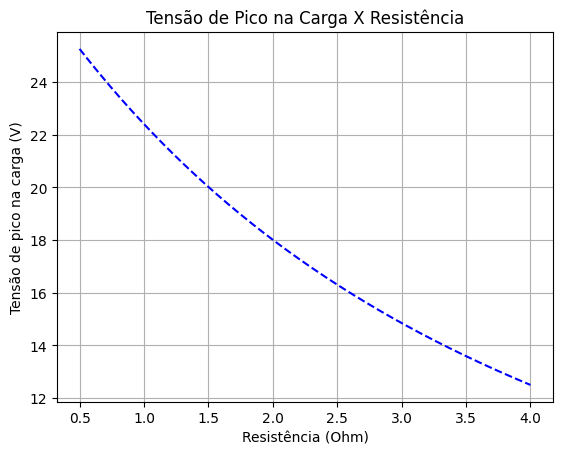

In [496]:
#Principais parâmetros para o projeto
Rc = 100
L1 = 0.0004622
L2 = 0.0004622
C = 150e-9
k_ideal = 0.17117117117117117

# Considerando que r1 = r2 = r
lista_r = np.arange(0.5, 4.01, 0.01)
lista_tensao_max = []
lista_tensao_pico_3 = []

for r in lista_r:
    f2 = freq_ressonancia.real
    i1_2, i2_2, _ = CalcularTransformador_projeto2(V_entrada, r, r, Rc, L1, L2, C, k_ideal, f2)
    w_2 = 2*pi*f2
    Z_eq_carga_3 = ((1/(1j*w_2*C))*Rc)/((1/(1j*w_2*C))+Rc)
    V_carga_3 = i2_2*Z_eq_carga_2
    lista_tensao_pico_3.append(abs(V_carga_3))

plt.plot(lista_r, lista_tensao_pico_3, 'b--')
plt.title("Tensão de Pico na Carga X Resistência")
plt.xlabel("Resistência (Ohm)")
plt.ylabel("Tensão de pico na carga (V)")
plt.grid(True)
plt.show()

#### O objetivo da conclusão é para entender como a resistencia das bobinas afetam a tensão de pico na carga. Como pode ser observado no gráfico, quanto maior a resistencia das bobinas, maior a queda da tensão.

### Ajustando Valores para considerar incertezas

#### V2 Ajustado

Tensão máxima no secundário: 15.500 V


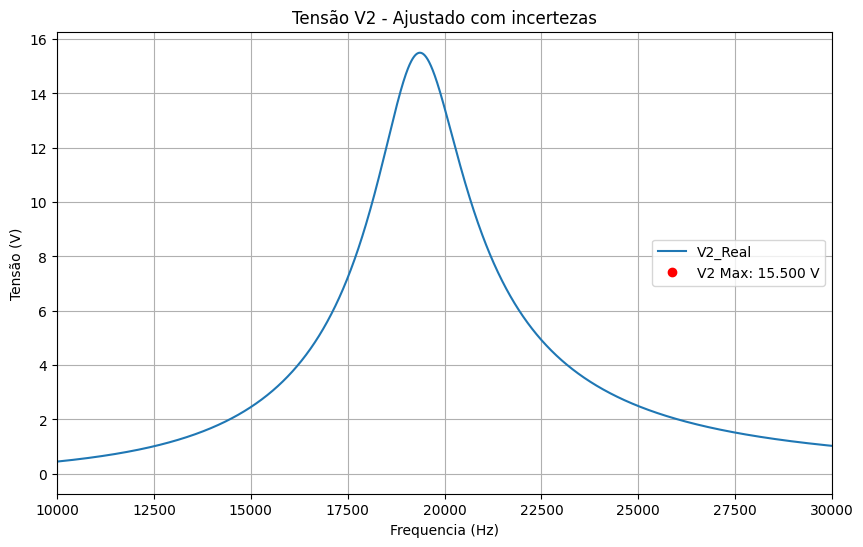

In [497]:
R1 = 1.620
R2 = 1.771
L1 = 0.0004622
L2 = 0.0004622
Rc = 100
K_ideal = 0.17117117117117117
C = 150e-9
lista_freq = np.linspace(10000, 100000, 10000)
V_entrada = 9*2/pi
incerteza = 1.3795 #Ohms

# Listas para armazenar valores
lista_i1_2 = []
lista_i2_2 = []
lista_v2_2 = []

# Cálculo de I1, I2 e V2 para cada frequência
for freq in lista_freq:
    I1_1, I2_1, V2_1 = CalcularTransformador_projeto2(V_entrada, R1 + incerteza, R2 + incerteza, Rc, L1, L2, C, K_ideal, freq)
    lista_i1_2.append(abs(I1_1))
    lista_i2_2.append(abs(I2_1))
    lista_v2_2.append(abs(V2_1))

# v2 max
v2_max = max(lista_v2_2)
print(f'Tensão máxima no secundário: {v2_max:.3f} V')

# Plotagem de V2
plt.figure(figsize=(10, 6))
plt.plot(lista_freq, lista_v2_2, label="V2_Real")
plt.title('Tensão V2 - Ajustado com incertezas')
plt.xlabel("Frequencia (Hz)")
plt.ylabel("Tensão (V)")
plt.xlim(10000, 30000)
plt.plot(freq_max, v2_max, 'ro', label=f'V2 Max: {v2_max:.3f} V')
plt.legend(loc = 'center right')
plt.grid(True)
plt.show()

#### Potência Ajustada

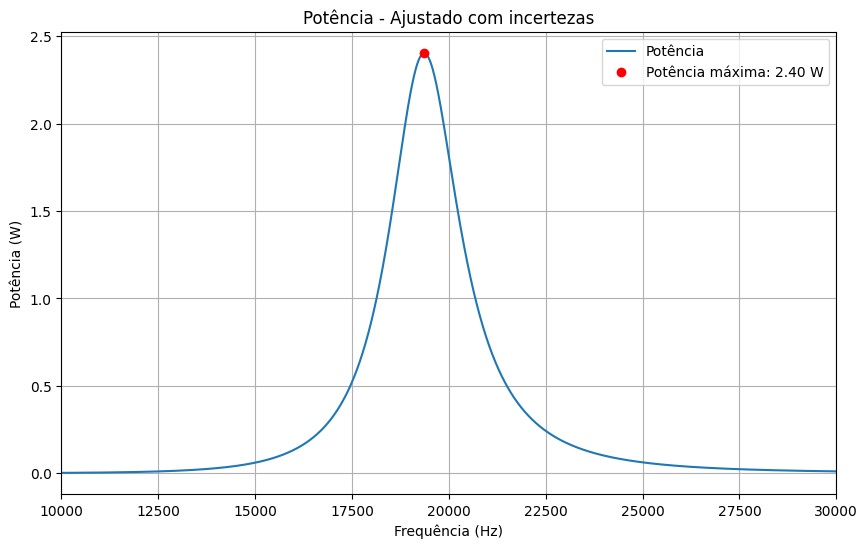

Frequência de ressonância: 19114.349889781566 Hz
Potência máxima na frequência de ressonância: 2.287 W
Potência máxima para k = K_ideal: 2.40 W


In [498]:
# potencia maxima na frequencia de ressonancia
freq_ressonancia = CalculaFrequenciaRessonancia(L2, C)
# Encontrar o índice mais próximo da frequência de ressonância
i_ressonancia = np.argmin(np.abs(lista_freq - freq_ressonancia))
i_max_potencia = np.argmax(lista_v2_2)

# Plotagem de Potencia (W) em função da frequência
lista_potencia = np.array(lista_v2_2)**2 / Rc
i_max_potencia = np.argmax(lista_potencia)

plt.figure(figsize=(10, 6))
plt.plot(lista_freq, lista_potencia, label="Potência")

# Ponto de potência máxima na frequência de ressonância
pot_max_na_ressonancia = lista_potencia[i_ressonancia]
freq_na_ressonancia = lista_freq[i_ressonancia]

pot_max = lista_potencia[i_max_potencia]
freq_max = lista_freq[i_max_potencia]

plt.plot(freq_max, pot_max, 'ro', 
         label=f'Potência máxima: {pot_max:.2f} W')

plt.title('Potência - Ajustado com incertezas')
plt.xlabel("Frequência (Hz)")
plt.ylabel("Potência (W)")
plt.xlim(10000, 30000)
plt.legend()
plt.grid(True)
plt.show()

print(f'Frequência de ressonância: {freq_ressonancia.real} Hz')
print(f'Potência máxima na frequência de ressonância: {lista_potencia[i_ressonancia]:.3f} W')
print(f'Potência máxima para k = K_ideal: {max(lista_potencia):.2f} W')